## 1. 필요한 패키지 불러오기

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils

## 2. 탐색적 자료 분석(EDA)

분석하기 편한 형태로 데이터를 정리합니다.

In [14]:
data = pd.read_csv("./data/titanic_train.csv") # csv 파일을 pd.DataFrame형태로 불러옵니다.
data = data.drop(columns=["PassengerId","Name","Cabin","Ticket"]) # DataFrame에 PassengerId,Name,Cabin,Ticket 열을 제거합니다.
data = data.dropna() # 결측값이 있는 행을 모두 제거 합니다.
data = data.reset_index().drop(columns=["index"]) # 결측값을 제거하며 꼬인 인덱스를 정리합니다.
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
707,0,3,female,39.0,0,5,29.1250,Q
708,0,2,male,27.0,0,0,13.0000,S
709,1,1,female,19.0,0,0,30.0000,S
710,1,1,male,26.0,0,0,30.0000,C


생존자 수를 구합니다. 생존 여부는 0이면 사망 1이면 생존이라는 의미 입니다.

In [15]:
data.groupby("Survived").count().iloc[:,0]

Survived
0    424
1    288
Name: Pclass, dtype: int64

입력변수중에서 질적 변수의 경우 분석이 가능한 형태로 만들기 위하여 가변수로 만들어 줍니다.

In [16]:
data["Pclass"] = pd.Categorical(data["Pclass"]) # Pclass를 범주형 변수로 지정합니다.
data = pd.get_dummies(data) # 모든 범주형 변수들의 가변수를 만들어 줍니다.
data

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0,39.0,0,5,29.1250,0,0,1,1,0,0,1,0
708,0,27.0,0,0,13.0000,0,1,0,0,1,0,0,1
709,1,19.0,0,0,30.0000,1,0,0,1,0,0,0,1
710,1,26.0,0,0,30.0000,1,0,0,0,1,1,0,0


입력변수중에서 양적 변수에 해당하는 Fare와 Age를 min_max 스케일링을 하여 0과 1사이의 값으로 변환해줍니다.

In [17]:
data["Fare"] = utils.minmax_scaling(data["Fare"])
data["Age"] = utils.minmax_scaling(data["Age"])

스케일링을 한 결과 최솟값은 0이고 최대값은 1이 되었습니다.

In [18]:
data.describe()[["Fare","Age"]]

,Fare,Age
count,712.000000,712.000000
mean,0.067471,0.367204
std,0.103329,0.182118
min,0.000000,0.000000
25%,0.015713,0.246042
50%,0.030539,0.346569
75%,0.064412,0.472229
max,1.000000,1.000000


모델을 구축하기 위한 형태로 입력변수 x와 출력변수 y를 나눕니다.

In [19]:
x = data.drop(columns=["Survived"]).values
y = data["Survived"].values.reshape(-1,1)

## 3. 모델 만들기

In [20]:
class Sigmoid:
    """
    활성화 함수 : 시그모이드 함수
    """
    def __init__(self):
        self.out = None
        
    # 순전파
    def forward(self, X):
        out = 1 / (1 + np.exp(-X))
        self.out = out
        return out
    # 역전파
    def backward(self, dout):
        return dout * (self.out * (1 - self.out))

In [21]:
class CrossEntropyLoss:
    """
    손실 함수 : 교차 엔트로피 함수
    """
    def __init__(self, pred):
        self.pred = pred
    # 순전파
    def forward(self, true):
        return -((true * np.log(self.pred + 1e-5)) + ((1 - true) * (np.log(1 - self.pred + 1e-5))))
    # 역전파
    def backward(self, true):
        return ((self.pred - true) / (self.pred * (1- self.pred)))

In [22]:
class Affine:
    """
    내적
    """
    def __init__(self, X, W, B):
        self.X = X
        self.W = W
        self.B = B
        self.dW = None
        self.dB = None
    # 순전파
    def forward(self):
        Z = np.dot(self.X, self.W) + self.B
        return Z
    # 역전파
    def backward(self, dout):
        self.dB = np.sum(dout, axis=0)
        self.dW = np.dot(self.X.T, dout)
        back = np.dot(dout, self.W.T)
        return back

In [ ]:
lr = 0.01
n_iter = 2

w1 = np.random.normal(size = (12, 100))
b1 = np.zeros(shape = (len(x),100))

w2 = np.random.normal(size = (100, 1))
b2 = np.zeros(shape = (len(x),1))


In [26]:
class Input_layer():
    def __init__(self, x):
        self.x = x
    def forward(self, units):
        number, columns = self.x.shape
        self.w = np.random.normal(size=(columns, units))
        self.b = np.zeros(shape=(units))
        layer = Affine(self.x, self.w, self.b)
        sig = Sigmoid()
        self.forward = layer.forward()
        self.sigmoid = sig.forward(self.forward)
        return self.sigmoid

**맨처음에 한번에 사용자 지정 가중치와 편향을 갯수만큼 만들고 하나씩 빼서 쓰ㄱ** 2021-04-03

In [34]:
class Hidden_layer():
    def __init__(self, x, after_units, layer_num):
        self.x = x
        self.unit_number = unit_number
        self.layer_num = layer_num
    def create_layer():
        number, before_units = self.x.shape
        self.bucket_w = np.random.normal(size=(before_units, after_units))
        self.bucket_b = np.zeros(shape=(after_units))
        

(100,)

In [24]:
def one_layer_fit(x, y, epochs=10:"int"):
    w1 = np.random.normal(size = (12, 100))
    b1 = np.zeros(shape = (len(x),100))

    w2 = np.random.normal(size = (100, 1))
    b2 = np.zeros(shape = (len(x),1))

    losses = []
    for i in tqdm(range(epochs)):
        # 순전파
        # 입력층
        layer0 = Affine(x, w1, b1)
        ex0 = layer0.forward()
        sig_layer0 = Sigmoid()
        sig_ex0 = sig_layer0.forward(ex0)
        # 은닉층
        layer1 = Affine(sig_ex0, w2, b2)
        ex1 = layer1.forward()
        sig_layer1 = Sigmoid()
        sig_ex1 = sig_layer1.forward(ex1)
        # 출력층
        layer2 = CrossEntropyLoss(sig_ex1)
        loss = np.mean(layer2.forward(y))
        losses += [loss]
        # 역전파
        dpred = layer2.backward(y)
        dsig_ex1 = sig_layer1.backward(dpred)
        dex1 = layer1.backward(dsig_ex1)
        dsig_ex0 = sig_layer0.backward(dex1)
        dex0 = layer0.backward(dsig_ex0)
        # 경사하강법으로 가중치 갱신
        w1 -= layer0.W * lr
        w2 -= layer1.W * lr
        b1 -= layer0.B * lr
        b2 -= layer1.B * lr
    return losses

C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\park\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


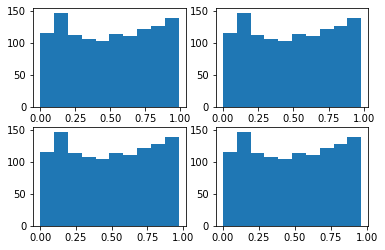

In [306]:
lr = 0.01
n_iter = 2

w1 = np.random.random(size = (12, 100))
b1 = np.zeros(shape = (len(x),100))

w2 = np.random.random(size = (100, 1))
b2 = np.zeros(shape = (len(x),1))

losses = []
fig, axes = plt.subplots(2,2)
axes = axes.ravel()
for ind,axis in enumerate(axes):
    # 순전파
    layer0 = Affine(x, w1, b1)
    ex0 = layer0.forward()
    sig_layer0 = Sigmoid()
    sig_ex0 = sig_layer0.forward(ex0)
    layer1 = Affine(sig_ex0, w2, b2)
    ex1 = layer1.forward()
    sig_layer1 = Sigmoid()
    sig_ex1 = sig_layer1.forward(ex1)

    layer2 = CrossEntropyLoss(sig_ex1)
    loss = np.mean(layer2.forward(y))
    losses += [loss]
    # 역전파
    dpred = layer2.backward(y)
    dsig_ex1 = sig_layer1.backward(dpred)
    dex1 = layer1.backward(dsig_ex1)
    dsig_ex0 = sig_layer0.backward(dex1)
    dex0 = layer0.backward(dsig_ex0)

    w1 -= layer0.W * lr
    w2 -= layer1.W * lr
    b1 -= layer0.B * lr
    b2 -= layer1.B * lr
    
    axis.hist(w1.flatten())

## 4. 모델 평가하기

In [ ]:
# ROC 커브

bucket_recall = []
bucket_fallout = []
threshold = np.arange(0,1,0.1)
for i in threshold:
    pred_y = A2.copy()
    pred_y = (pred_y > i )
    true_y = (y == 1)

    matrix = np.concatenate([pred_y,true_y], axis=1)

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for pred, true in matrix:
        if pred == True and true == True:
            TP += 1
        elif pred == True and true == False:
            FP += 1
        elif pred == False and true == True:
            TN += 1
        elif pred == False and true == False:
            FN += 1
    confusion_matrix = np.array([[TP,TN],
                                [FP,FN]])
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    accuracy = (TP + FN) / (TP + TN + FP + FN)
    fallout = FP / (TN + FP)

    bucket_recall.append(recall)
    bucket_fallout.append(fallout)

In [ ]:
plt.plot(bucket_recall, bucket_fallout)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [ ]:
bucket_recall

In [ ]:
bucket_fallout

In [ ]:
# auc curve가 급격하게 변화하는 지점의 threshold값은 0.4 입니다.
threshold[4]

In [ ]:
pred_y = A2.copy()
pred_y = (pred_y > 0.4 )
true_y = (y == 1)

matrix = np.concatenate([pred_y,true_y], axis=1)

TP = 0
TN = 0
FP = 0
FN = 0
for pred, true in matrix:
    if pred == True and true == True:
        TP += 1
    elif pred == True and true == False:
        FP += 1
    elif pred == False and true == True:
        TN += 1
    elif pred == False and true == False:
        FN += 1
confusion_matrix = np.array([[TP,TN],
                            [FP,FN]])
recall = TP / (TP + FN)
precision = TP / (TP + FP)
accuracy = (TP + FN) / (TP + TN + FP + FN)

In [ ]:
# threshold가 0.4 일때의 가장 성능이 좋은 모델이라는 결론이 나왔습니다.
accuracy